In [ ]:
import os
import io
import json
import time
import random
from datetime import datetime
from typing import Dict, Tuple, Optional, List
from dataclasses import dataclass
from collections import defaultdict

# Temel Bilimsel Paketler
import numpy as np
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch & TorchVision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Veri Bölme & Değerlendirme
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Google Drive (Colab için)
from google.colab import drive

# Grad-CAM (ısı haritaları için)
from torch.autograd import Function
import cv2  # Grad-CAM görselleştirme için opsiyonel

# Rastgelelik için seed kontrolü
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

print("Tüm kütüphaneler başarıyla import edildi!")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name()}")

Tüm kütüphaneler başarıyla import edildi!
PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Device: NVIDIA L4


Bu fonksiyonun amacı deneysel tekrarlanabilirlik sağlamak, yani her seferinde aynı “seed” ile çalıştırıldığında benzer sonuçları almamızı kolaylaştırmaktır. Derin öğrenmede bazı işlemler (parametrelerin rastgele başlatılması, shuffle, dropout, GPU kernel seçimi vs.) doğası gereği rastgelelik içerir. Bu fonksiyon, bu rastgeleliği kontrol altına alır.

CNN eğitiminde sabit seed kullanmamın sebepleri:

**Karşılaştırılabilirlik:** Yeni augmentasyon, loss fonksiyonu veya optimizer değiştirince, önceki denemeyle adil karşılaştırma yapabilmemizi sağlar.

**Debug kolaylığı:** Eğitim sırasında garip bir şey olduğunda, aynı koşulları tekrar çalıştırarak hatayı daha kolay yakalayabilmemizi sağlar.

**Reprodüksiyon:** Notebook’u farklı zamanlarda açtığında veya başkasına verdiğinde aynı başlangıçtan gidilmesini sağlar.

In [ ]:
def set_seed(seed: int = 42):
    # Python'un random modülündeki rastgele sayı üretimini sabitler.
    random.seed(seed)

    # NumPy içindeki rastgele sayı üretimini sabitler (örneğin shuffle, random array üretme).
    np.random.seed(seed)

    # PyTorch'un CPU tarafındaki rastgeleliği sabitler.
    torch.manual_seed(seed)

    # PyTorch'un GPU tarafındaki tüm GPU’larda (multi-GPU varsa) rastgeleliği sabitler.
    torch.cuda.manual_seed_all(seed)

    # CUDA'nın deterministik davranmasını sağlar.
    # Aynı giriş her seferinde aynı sonucu üretsin diye bazı nondeterministic kernel seçimlerini engeller.
    torch.backends.cudnn.deterministic = True

    # Performans optimizasyonu: True olunca, PyTorch farklı algoritmalar arasında benchmark yapar
    # ve en hızlısını seçer. (Deterministic=True ile çelişebilir, bazen tekrarlanabilirliği bozabilir.)
    torch.backends.cudnn.benchmark = True

Aşağıdaki hücrede veri setleri tanımlanmıştır.

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Human Action Recognition"

# Dosya yolları
TRAIN_CSV = os.path.join(DATA_DIR, "Training_set.csv")
TEST_CSV = os.path.join(DATA_DIR, "Testing_set.csv")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Yolların kontrolü
for path in [TRAIN_CSV, TEST_CSV, TRAIN_DIR, TEST_DIR]:
    if os.path.exists(path):
        print(f"✓ {path}")
    else:
        print(f"✗ {path} - BULUNAMADI!")

✓ /content/drive/MyDrive/Human Action Recognition/Training_set.csv
✓ /content/drive/MyDrive/Human Action Recognition/Testing_set.csv
✓ /content/drive/MyDrive/Human Action Recognition/train
✓ /content/drive/MyDrive/Human Action Recognition/test


Aşağıdaki hücrede veri setindeki örnek görüntüler, etiketleri ve etiketlere ait görsel sayıları gösterilmiştir.

İlk 5 örnek:
      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

Toplam örnek sayısı: 12600
Toplam sınıf sayısı: 15
Sınıf isimleri: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']

Sınıf dağılımı:
label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64


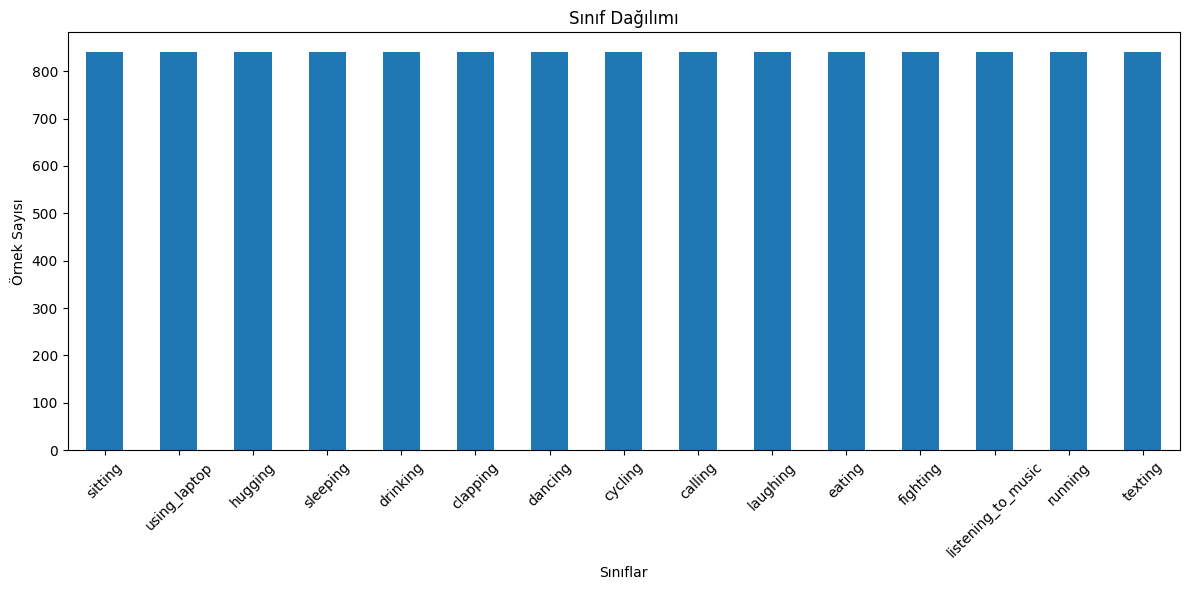

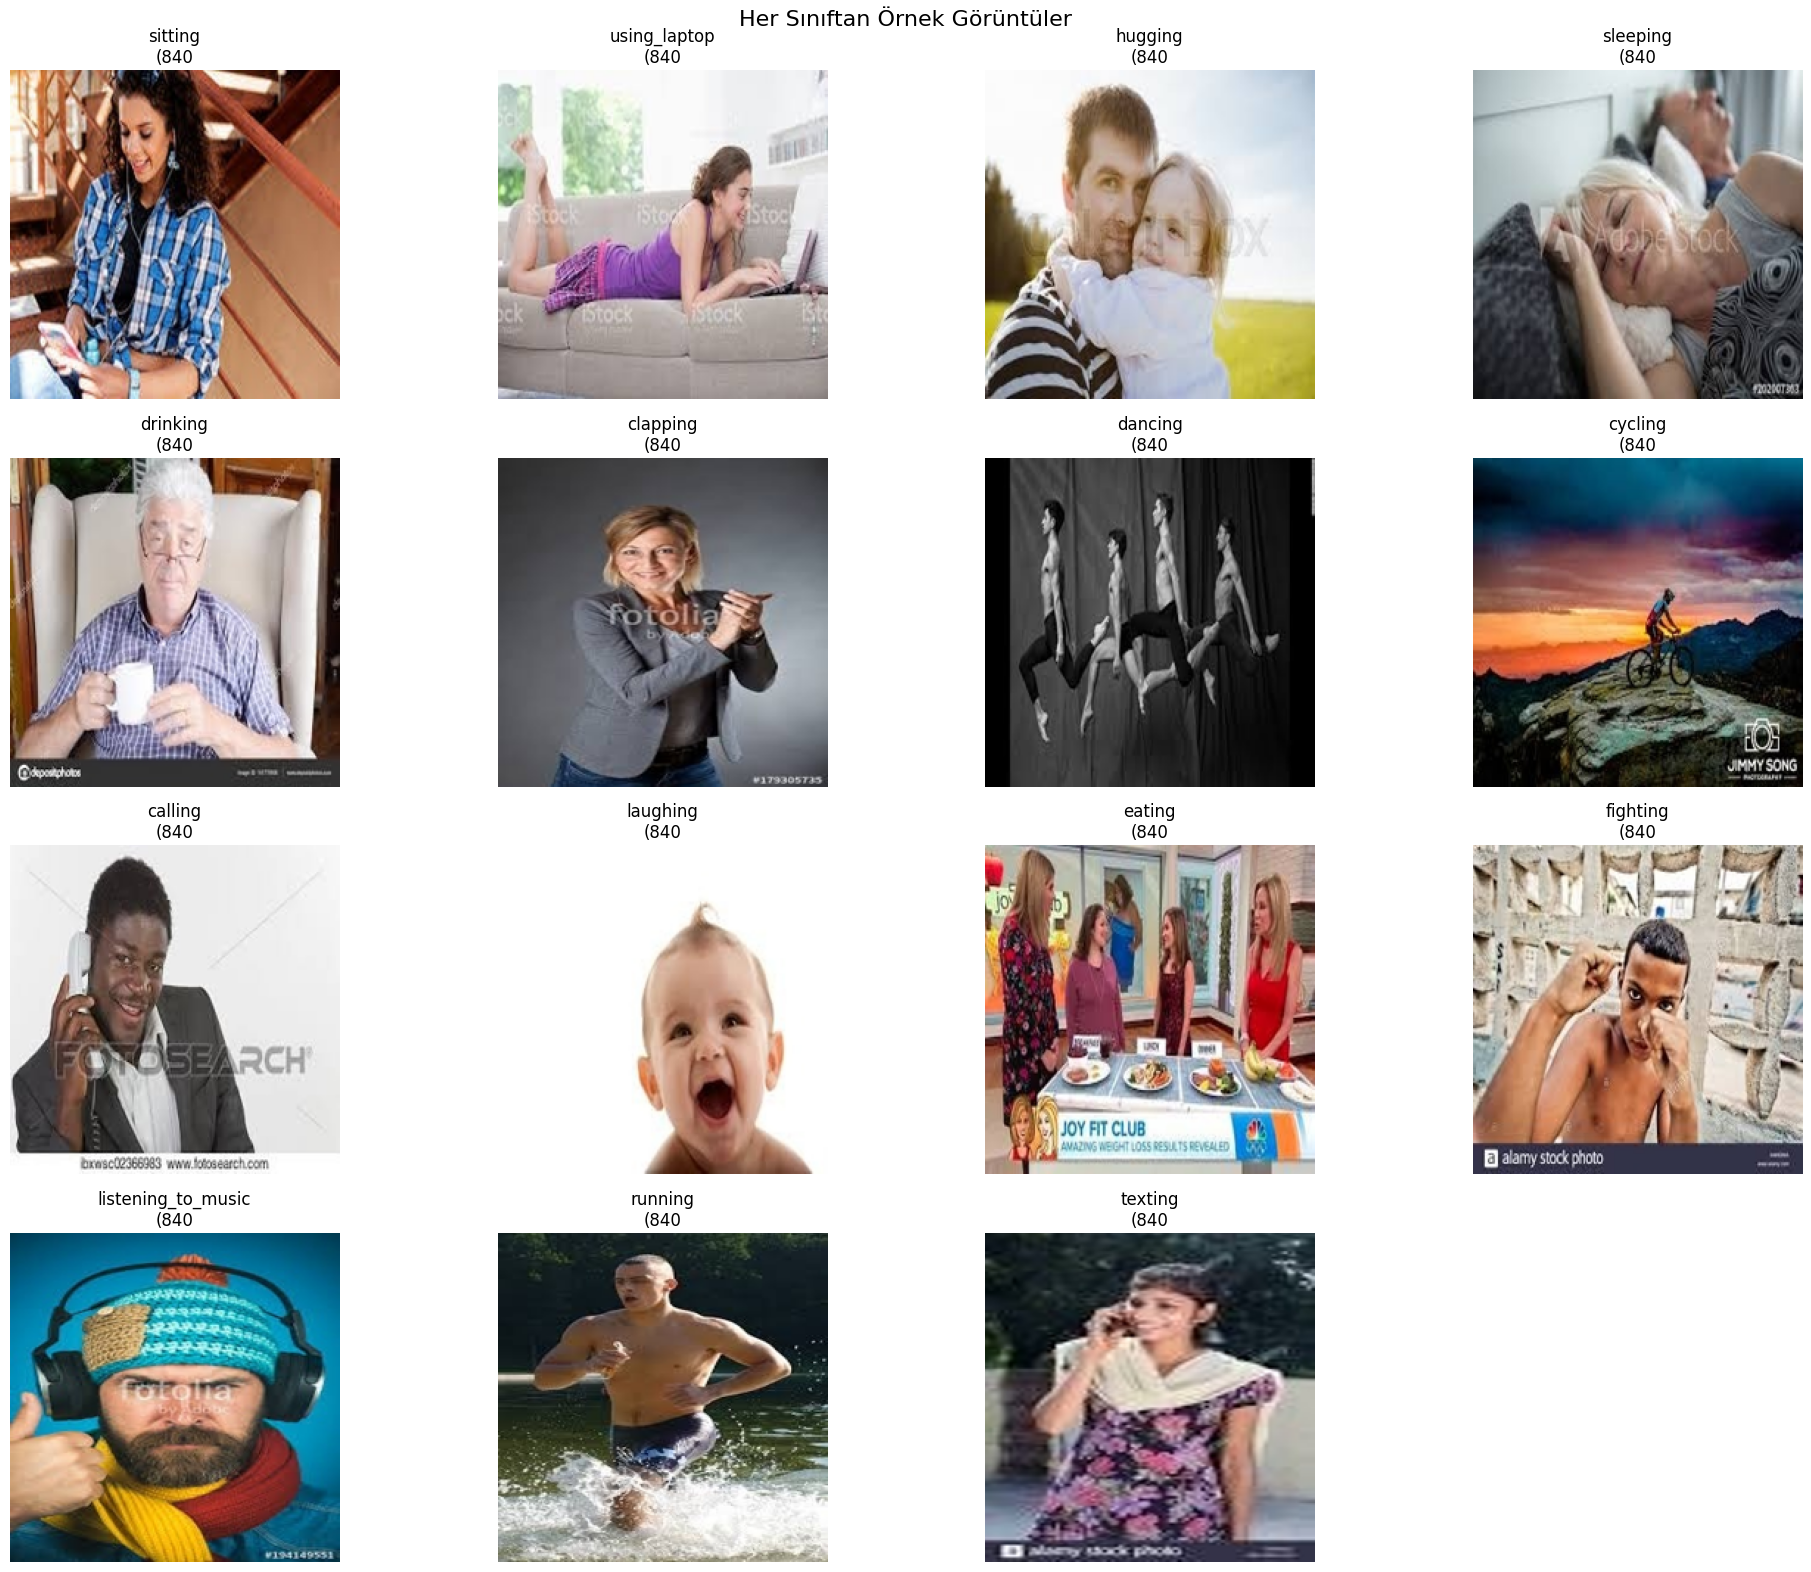

In [ ]:
df = pd.read_csv(TRAIN_CSV)
print("İlk 5 örnek:")
print(df.head())

print(f"\nToplam örnek sayısı: {len(df)}")
print(f"Toplam sınıf sayısı: {df['label'].nunique()}")
print(f"Sınıf isimleri: {sorted(df['label'].unique())}")

# Sınıf dağılımı
print("\nSınıf dağılımı:")
class_counts = df['label'].value_counts()
print(class_counts)

# Sınıf dağılım grafiği
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Sınıf Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Her sınıftan örnek görüntüler
plt.figure(figsize=(20, 16))
unique_labels = df['label'].unique()

for i, label in enumerate(unique_labels, 1):
    row = df[df['label'] == label].iloc[0]
    img_path = os.path.join(TRAIN_DIR, row['filename'])

    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))

        plt.subplot(4, 4, i)
        plt.imshow(img)
        plt.title(f'{label}\n({class_counts[label]}')
        plt.axis('off')

plt.suptitle('Her Sınıftan Örnek Görüntüler', fontsize=16)
plt.tight_layout()
plt.show()

Aşağıdaki hücrenin amacı:

* Train ve validation veri setlerini ayırmak.

* CNN modelin label’ları sayısal indexlerle kullanabilmesi için gerekli mapping’i hazırlamak.

* Eğitimde doğru bir değerlendirme yapmak için veriyi train/val olarak dengeli bir şekilde bölmektir.

**Bu hücre sayesinde eğitim verisi %15 oranında validation veri seti oluşturulmuştur.**

In [ ]:
def make_label_map(train_csv_path: str) -> Tuple[Dict[str, int], Dict[int, str]]:
    """Label'ları index'lere dönüştürme"""
    df = pd.read_csv(train_csv_path)   # CSV dosyasını oku
    if 'label' not in df.columns:      # 'label' sütunu var mı kontrol et
        raise ValueError("CSV'de 'label' sütunu bulunmalı.")

    # Tüm eşsiz class label’larını string olarak al, sıralı listeye çevir
    classes = sorted(df['label'].astype(str).unique().tolist())

    # Her label’a bir integer index ata (0,1,2,…)
    label2idx = {c: i for i, c in enumerate(classes)}
    # Tersi mapping (index → label)
    idx2label = {i: c for c, i in label2idx.items()}

    # Mapping’i JSON dosyasına kaydet (sonradan aynı indexleri kullanabilmek için)
    out_path = os.path.join(DATA_DIR, 'label_map.json')
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump({'label2idx': label2idx, 'idx2label': idx2label}, f, ensure_ascii=False, indent=2)

    return label2idx, idx2label   # Fonksiyon mappingleri döndürür


# Train/validation split
def split_train_val(train_csv_path: str, val_size: float = 0.15, seed: int = 42):
    """Stratified train/val split"""
    df = pd.read_csv(train_csv_path)   # CSV dosyasını oku
    # Stratified split (her class’tan orantılı miktarda örnek ayırır)
    train_df, val_df = train_test_split(
        df, test_size=val_size, random_state=seed, stratify=df['label']
    )
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)

# Label mapping oluştur
label2idx, idx2label = make_label_map(TRAIN_CSV)
print(f"Label mapping oluşturuldu: {len(label2idx)} sınıf")
print(f"İlk 5 sınıf: {list(label2idx.items())[:15]}")

# Train/validation split
train_df, val_df = split_train_val(TRAIN_CSV, val_size=0.15, seed=42)
print(f"\nTrain örnekleri: {len(train_df)}")
print(f"Validation örnekleri: {len(val_df)}")

Label mapping oluşturuldu: 15 sınıf
İlk 5 sınıf: [('calling', 0), ('clapping', 1), ('cycling', 2), ('dancing', 3), ('drinking', 4), ('eating', 5), ('fighting', 6), ('hugging', 7), ('laughing', 8), ('listening_to_music', 9), ('running', 10), ('sitting', 11), ('sleeping', 12), ('texting', 13), ('using_laptop', 14)]

Train örnekleri: 10710
Validation örnekleri: 1890


Aşağıdaki hücre; eğitimde kullanılacak görüntü ön-işleme ve data augmentation (veri artırma) adımlarını tanımlar ve seçer. CNN’lerde bu adımlar çok kritiktir çünkü:

* **Genelleme:** Modelin gerçek hayatta görmediği varyasyonlara (döndürme, parlaklık değişimi, perspektif bozulmaları vb.) daha iyi uyum sağlamasını sağlar.

* **Aşırı öğrenmeyi azaltır:** Aynı görselin farklı sürümlerini görerek ezber yerine öğrenme yapar.

* **Dağılım eşleşmesi:** Eğitim ve doğrulama/testte tutarlı normalizasyon kullanarak giriş dağılımını sabitler.

* **Performans:** Doğru/tutarlı augmentations ile doğruluk ve dayanıklılık artar.

In [ ]:
USE_ENHANCED_AUG = True  # True ise güçlendirilmiş (daha agresif) augmentations kullan; False ise klasik/temel seti kullanır.

IMAGENET_MEAN = [0.485, 0.456, 0.406]  # ImageNet ortalamaları (kanal başına) – Normalize için kullanılır.
IMAGENET_STD  = [0.229, 0.224, 0.225]  # ImageNet standart sapmaları (kanal başına).

import torchvision.transforms as T  # PyTorch'un resim dönüşümleri (augment/normalize) için modülü.

def get_transforms_classic(img_size=224):
    # İlk paylaştığın kodla bire bir aynı temel augmentations (daha hafif ve güvenli).
    train_transform = T.Compose([                      # Eğitimde ardışık dönüşümleri sırala.
        T.Resize(int(img_size * 1.15)),               # Hafifçe büyüt (crop için marj bırakır).
        T.RandomResizedCrop(img_size,                 # Rastgele yeniden ölçekleyip kırp (ölçek/oran aralığı ile).
                            scale=(0.7, 1.0),
                            ratio=(0.75, 1.33)),
        T.RandomHorizontalFlip(p=0.5),                # %50 olasılıkla yatay çevir (poz varyasyonu).
        T.RandomApply([T.RandomRotation(15)], p=0.3), # %30 olasılıkla ±15° döndür (açı varyasyonu).
        T.RandomApply([T.RandomAffine(                 # %30 olasılıkla küçük öteleme (global geometri).
            degrees=0, translate=(0.05, 0.05))], p=0.3),
        T.RandomApply([T.ColorJitter(                  # %30 olasılıkla renk/parlaklık/kontrast oynatma.
            brightness=0.2, contrast=0.2,
            saturation=0.2, hue=0.05)], p=0.3),
        T.ToTensor(),                                  # PIL → Tensor (0–1 aralığına ölçekler).
        T.Normalize(mean=IMAGENET_MEAN,                # ImageNet istatistikleriyle normalize et
                    std=IMAGENET_STD),                 # (önceden eğitilmiş ağlarla uyum ve stabilite).
        T.RandomErasing(p=0.25,                        # %25 olasılıkla küçük bir yama sil (regularization).
                        scale=(0.02, 0.15),
                        ratio=(0.3, 3.3),
                        value='random'),
    ])
    val_transform = T.Compose([                        # Doğrulama/testte deterministik ve hafif pipeline.
        T.Resize(int(img_size * 1.15)),                # Hafifçe yeniden boyutlandır.
        T.CenterCrop(img_size),                        # Ortadan kırp (tekrar üretilebilirlik için).
        T.ToTensor(),                                  # PIL → Tensor.
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),  # Eğitimle aynı normalize.
    ])
    return train_transform, val_transform               # Eğitim ve validasyon dönüşümlerini döndür.

def get_transforms_enhanced(img_size=224):
    # Daha güçlü augmentation (daha fazla çeşitlilik → daha iyi genelleme; aşırı uyumsuzluk yoksa genelde daha iyi).
    train_transform = T.Compose([
        T.Resize((img_size + 32, img_size + 32)),      # Biraz daha büyük kenar (daha agresif crop için alan).
        T.RandomResizedCrop(img_size,                  # Rastgele ölçek/oran kırpma (geniş varyasyon).
                            scale=(0.7, 1.0),
                            ratio=(0.75, 1.33)),
        T.RandomHorizontalFlip(p=0.5),                 # Yatay flip.
        T.RandomVerticalFlip(p=0.2),                   # Dikey flip (hareket sınıfları uygunsa faydalı).
        T.RandomRotation(degrees=20),                  # ±20° döndürme (açı çeşitliliği).
        T.ColorJitter(brightness=0.3, contrast=0.3,    # Daha güçlü fotometrik jitter (ışık/kontrast doygunluk).
                      saturation=0.3, hue=0.1),
        T.RandomAffine(degrees=15,                     # Dönüş + öteleme + ölçek (geometrik çeşitlilik).
                       translate=(0.1, 0.1),
                       scale=(0.9, 1.1)),
        T.RandomPerspective(distortion_scale=0.2, p=0.3),  # %30 olasılıkla perspektif bozulması (robustluk).
        T.ToTensor(),                                   # PIL → Tensor.
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), # Normalize (aynı istatistikler).
        T.RandomErasing(p=0.3,                          # Biraz daha agresif erasing (overfit azaltma).
                        scale=(0.02, 0.2),
                        ratio=(0.3, 3.3),
                        value='random'),
    ])
    val_transform = T.Compose([                         # Validasyon/test boru hattı (sabit, hafif).
        T.Resize((img_size, img_size)),                 # Doğrudan hedef boyuta resize (deterministik).
        T.ToTensor(),                                   # PIL → Tensor.
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), # Aynı normalize.
    ])
    return train_transform, val_transform                # Eğitim ve validasyon dönüşümlerini döndür.

# Kullanım
IMG_SIZE = 224                                           # Hedef giriş boyutu (modelin beklediği).
if USE_ENHANCED_AUG:
    train_transform, val_transform = get_transforms_enhanced(IMG_SIZE)  # Güçlü seti seç.
else:
    train_transform, val_transform = get_transforms_classic(IMG_SIZE)    # Klasik seti seç.


Bu hücredeki amaç:

* HAM (Human Action Recognition) datasetini CNN eğitimine uygun hale getirir.

* CSV’deki filename ve label bilgilerini kullanarak görselleri yükler.

* Data augmentation (transformlar) uygular.

* Eğitim (train), doğrulama (val) ve test (test) için ayrı dataset nesneleri oluşturur.

* Veriyi PyTorch Dataset standardına ayarlar.

* Böylece DataLoader ile batch’ler halinde veriyi GPU’ya gönderebiliyoruz.

* Eğitim sırasında modelin __getitem__ fonksiyonu her çağrıldığında ilgili resmi okuyor, dönüştürüyor ve label ile birlikte döndürür.

Label mapping (etiket → index):

* CNN modelleri sayılarla ifade edilmiş etiketlere ihtiyaç duyar (örneğin "walking" → 0, "running" → 1).

* Bu mapping burada uygulanıyor.

Transform/augmentation:

* train_transform → eğitim sırasında resimlere crop, flip, rotation, normalize gibi dönüşümler uygulanıyor.

* val_transform → doğrulama ve testte sadece normalize ediliyor.

Dataset ayrımı:

* train_dataset: Modeli eğitmek için (augmentasyonlu).

* val_dataset: Modeli doğrulamak için (augmentasyonsuz).

* test_dataset: Etiketleri bilinmeyen (submission için) veriler.

**Bu hücre, CNN eğitiminde kullanılacak özel bir PyTorch Dataset sınıfını tanımlar. CSV dosyasından resim yollarını ve etiketleri okur, gerektiğinde augmentasyon uygular, etiketleri sayısallaştırır ve PyTorch DataLoader ile batch’lenebilir hale getirir. Eğitim, doğrulama ve test datasetleri bu sınıf kullanılarak hazırlanır.**

In [ ]:
@dataclass
class HARSample:
    image: torch.Tensor
    target: Optional[int]
    filename: str

class HARDataset(Dataset):
    """Human Action Recognition Dataset"""

    def __init__(
        self,
        df: Optional[pd.DataFrame] = None,
        csv_path: Optional[str] = None,
        images_dir: str = '.',
        transform: Optional[transforms.Compose] = None,
        label2idx: Optional[Dict[str, int]] = None,
        has_labels: bool = True,
    ):
        if df is None and csv_path is None:
            raise ValueError("df veya csv_path verilmeli.")

        self.df = df if df is not None else pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.transform = transform
        self.has_labels = has_labels and ('label' in self.df.columns)
        self.label2idx = label2idx

        # Dosya yolları
        self.filepaths = [
            os.path.join(self.images_dir, str(x))
            for x in self.df['filename'].astype(str)
        ]

        # Hedefler
        if self.has_labels:
            if self.label2idx is None:
                classes = sorted(self.df['label'].astype(str).unique().tolist())
                self.label2idx = {c: i for i, c in enumerate(classes)}
            self.targets = [
                self.label2idx[str(y)]
                for y in self.df['label'].astype(str)
            ]
        else:
            self.targets = None

    def __len__(self):
        return len(self.filepaths)

    def _load_image(self, path: str) -> Image.Image:
        """Güvenli image loading"""
        try:
            with Image.open(path) as img:
                return img.convert('RGB')
        except Exception as e:
            raise FileNotFoundError(f"Görüntü yüklenemedi: {path} -> {e}")

    def __getitem__(self, idx: int):
        path = self.filepaths[idx]
        img = self._load_image(path)

        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        if self.has_labels:
            target = int(self.targets[idx])
            return img, target
        else:
            return img, os.path.basename(path)

# Dataset'leri oluştur
print("Dataset'ler oluşturuluyor...")

train_dataset = HARDataset(
    df=train_df,
    images_dir=TRAIN_DIR,
    transform=train_transform,
    label2idx=label2idx,
    has_labels=True
)

val_dataset = HARDataset(
    df=val_df,
    images_dir=TRAIN_DIR,
    transform=val_transform,
    label2idx=label2idx,
    has_labels=True
)

test_dataset = HARDataset(
    csv_path=TEST_CSV,
    images_dir=TEST_DIR,
    transform=val_transform,
    label2idx=label2idx,
    has_labels=False
)

print(f"Train dataset: {len(train_dataset)} örnekler")
print(f"Val dataset: {len(val_dataset)} örnekler")
print(f"Test dataset: {len(test_dataset)} örnekler")

Dataset'ler oluşturuluyor...
Train dataset: 10710 örnekler
Val dataset: 1890 örnekler
Test dataset: 5400 örnekler


Dataset’leri DataLoader’a çevirir → Mini-batch halinde GPU’ya gönderilmesini sağlar.

Data augmentation’un çalışıp çalışmadığını kontrol eder → İlk batch’ten örnek görselleri çizdirerek kontrolü sağlar.

DataLoader sayesinde:

* Eğitim sırasında shuffle=True ile veriler karıştırılır (overfitting’i engeller).

* Validation ve testte shuffle=False olur (tahminler sabit sırayla yapılır).

* batch_size=64 ile GPU verimli kullanılır.

* pin_memory=True CUDA kullanılıyorsa veri aktarımını hızlandırır.

**Görselleştirme sayesinde, uygulanan data augmentation (crop, flip, color jitter, rotation, vb.) doğru çalıştığının tespitini yapabilmemizi sağlar.**

DataLoader'lar oluşturuldu:
Train batches: 168
Val batches: 30
Test batches: 85
Batch shape: torch.Size([64, 3, 224, 224])


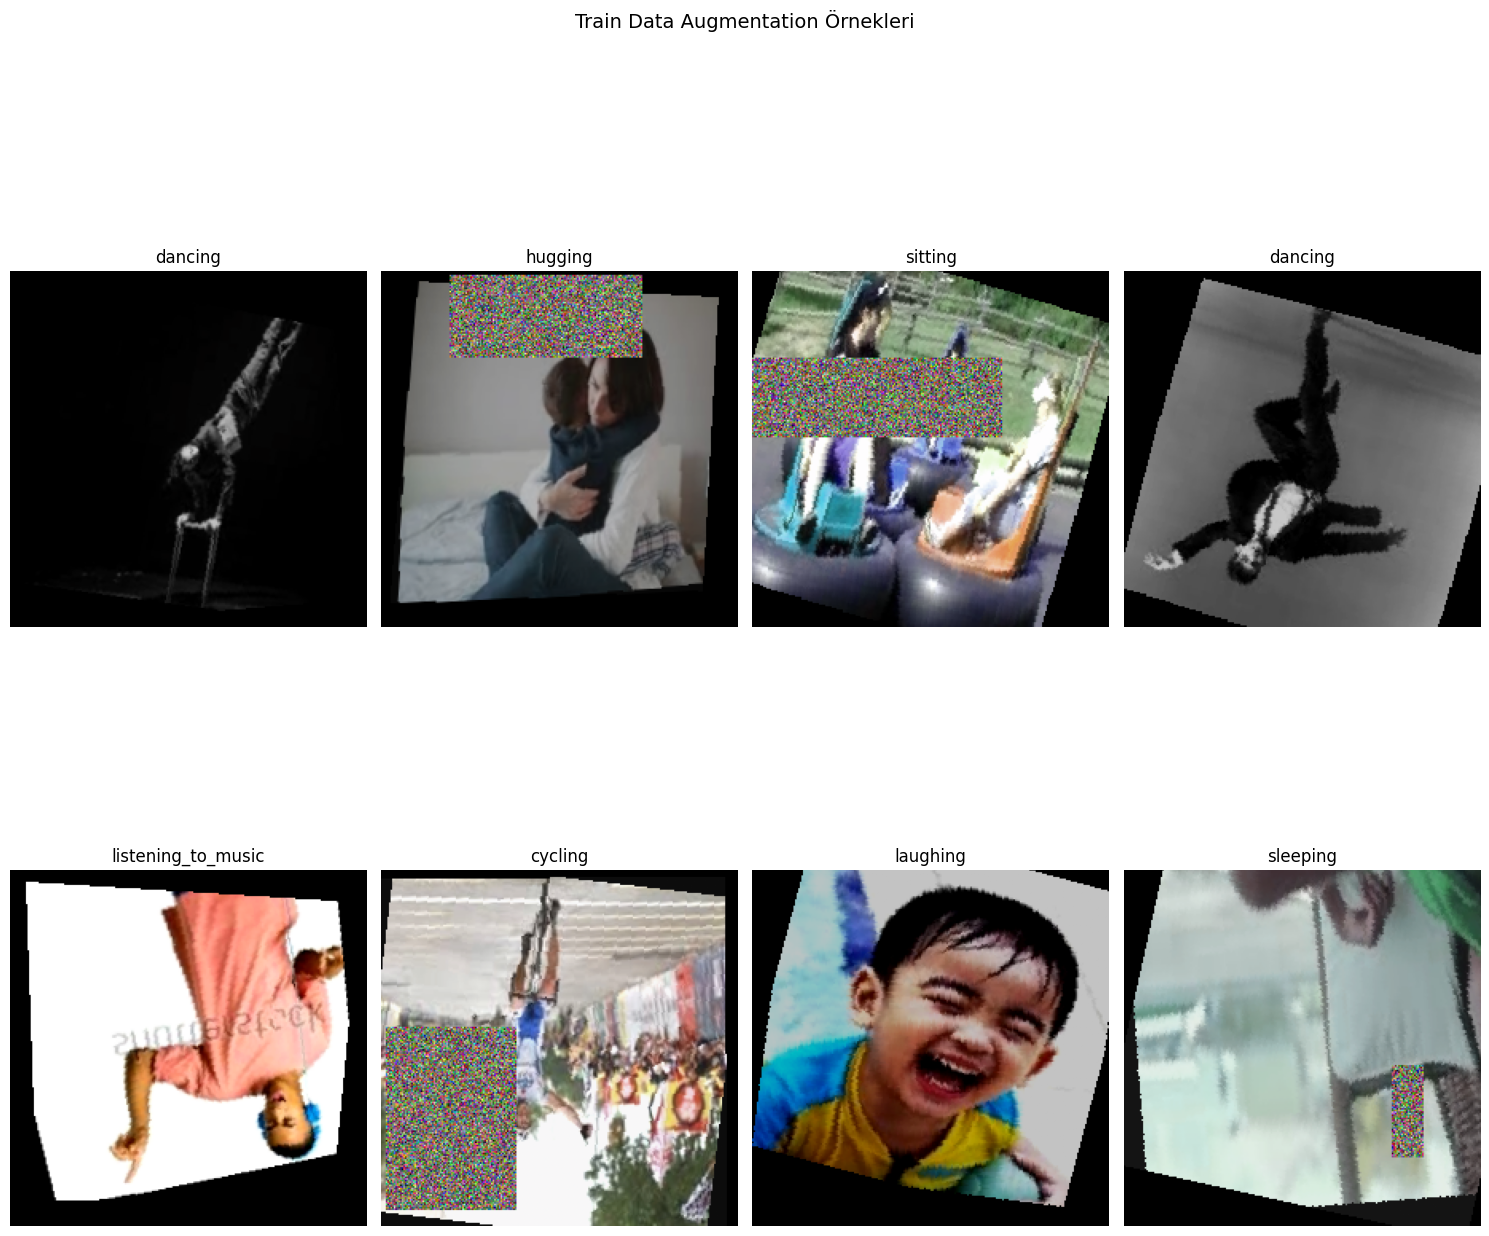

In [ ]:
def create_dataloaders(train_ds, val_ds, test_ds, batch_size=64, num_workers=2):
    """DataLoader'ları oluştur"""

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
        drop_last=False
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
        drop_last=False
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
        drop_last=False
    )

    return train_loader, val_loader, test_loader

# DataLoader'ları oluştur
BATCH_SIZE = 64
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=BATCH_SIZE, num_workers=2
)

print(f"DataLoader'lar oluşturuldu:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Augmentation örneklerini görselleştir
def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Normalize edilmiş tensörü geri dönüştür"""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

# Bir batch al ve görselleştir
imgs, targets = next(iter(train_loader))
print(f"Batch shape: {imgs.shape}")

# İlk 8 görseli göster
fig, axes = plt.subplots(2, 4, figsize=(15, 15))
axes = axes.ravel()

for i in range(8):
    img = denormalize(imgs[i]).clamp(0, 1)
    img = img.permute(1, 2, 0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(f'{idx2label[targets[i].item()]}')
    axes[i].axis('off')

plt.suptitle('Train Data Augmentation Örnekleri', fontsize=14)
plt.tight_layout()
plt.show()

SE blok, CNN mimarilerinde kullanılan bir attention mekanizmasıdır ve modelin hangi kanalların daha önemli olduğunu öğrenmesini sağlar.

Bu hücrenin CNN eğitimindeki Rolü

* CNN’in feature map’lerinde bazı kanallar
diğerlerinden daha anlamlı olabilir.
SE Block, global bağlam bilgisi kullanarak her kanala bir önem katsayısı atar.
Böylece ağ önemli kanalları güçlendirir, önemsizleri bastırır → daha iyi temsil gücü ve doğruluk artışı sağlar.

In [ ]:
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block (Attention Mechanism)"""

    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)   # Her kanalı global olarak özetler (H,W → 1x1).
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),  # Kanal sayısını küçült (bottleneck).
            nn.ReLU(inplace=True),                                   # Aktivasyon.
            nn.Linear(channels // reduction, channels, bias=False),  # Kanal boyutuna geri dön.
            nn.Sigmoid()                                             # Kanal başına 0-1 ölçek katsayısı üret.
        )

    def forward(self, x):
        b, c, _, _ = x.size()                     # Batch ve kanal boyutlarını al.
        se = self.squeeze(x).view(b, c)           # (B,C,H,W) → (B,C,1,1) → (B,C).
        se = self.excitation(se).view(b, c, 1, 1) # Kanal katsayılarını hesapla ve (B,C,1,1)'e reshape et.
        return x * se.expand_as(x)                # Girişi kanal katsayılarıyla çarp → yeniden ağırlıklandırma.


# Test SE Block
se_block = SEBlock(64)                                  # 64 kanallı SE blok oluştur.
test_tensor = torch.randn(2, 64, 32, 32)                # Rastgele giriş: (batch=2, channels=64, H=32, W=32)
output = se_block(test_tensor)                          # SE bloktan geçir.
print(f"SE Block test - Input: {test_tensor.shape}, Output: {output.shape}")

SE Block test - Input: torch.Size([2, 64, 32, 32]), Output: torch.Size([2, 64, 32, 32])


Residual bağlantılar sayesinde çok derin CNN’lerde ortaya çıkan gradient kaybolması sorununu azaltmak.

Her blokta 2D convolution → batch normalization → ReLU işlemleri yaparak özellik çıkarımı yapmak.

Opsiyonel olarak SEBlock (attention) ekleyerek önemli kanalları vurgulamak.

Dropout kullanarak overfitting’i azaltmak.

Skip connection (shortcut) ile giriş bilgisini de çıkışa ekleyerek öğrenmeyi kolaylaştırmak.

Bu blok, modelinin temel bileşenlerinden biri. EnhancedCNN içindeki layer1, layer2, ... yapıları aslında bu ResidualBlock’ların art arda dizilmesinden oluşuyor.
Girdiyi işlerken üç convolutional katman kullanıyor.

* Skip connection ile giriş bilgisini koruyor → model, “farkı” öğreniyor.

* SEBlock sayesinde kanal bazlı dikkat mekanizması ekleniyor.

* Dropout, regularization sağlayarak overfitting’i azaltıyor.

* Böylece, model derinleştikçe bile öğrenme kolaylaşıyor ve daha iyi doğruluk elde ediliyor.

In [ ]:
class ResidualBlock(nn.Module):


    def __init__(self, in_channels, out_channels, stride=1, use_se=True, dropout_rate=0.0):
        super().__init__()
        self.use_se = use_se
        self.dropout_rate = dropout_rate

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # SE Block
        if use_se:
            self.se = SEBlock(out_channels)

        # Dropout
        if dropout_rate > 0:
            self.dropout = nn.Dropout2d(dropout_rate)

        # Skip connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.use_se:
            out = self.se(out)

        if self.dropout_rate > 0:
            out = self.dropout(out)

        out += self.shortcut(residual)
        out = F.relu(out)

        return out

# Test Residual Block
res_block = ResidualBlock(64, 128, stride=2, use_se=True)
test_tensor = torch.randn(2, 64, 32, 32)
output = res_block(test_tensor)
print(f"Residual Block test - Input: {test_tensor.shape}, Output: {output.shape}")

Residual Block test - Input: torch.Size([2, 64, 32, 32]), Output: torch.Size([2, 128, 16, 16])


CNN model mimarisini tanımlamak (katmanlar, bloklar, classifier kısmı).

Attention (SE Block), residual bağlantılar, dropout, batch normalization gibi gelişmiş tekniklerle modelin daha iyi genelleşmesini sağlamak.

Sonunda modelin çıkış katmanı, kaç sınıf varsa ona uygun (num_classes) bir vektör üretiyor → softmax uygulanarak sınıflandırmaya hazır hale geliyor.

**Stem:** İlk convolution + pooling katmanları ile resimleri düşük seviyeli özelliklere (kenar, doku vb.) ayırır.

**Residual Layers:** Derinliği artırırken "residual connections" sayesinde gradient kaybolma sorununu azaltır.

**SE Block (Attention):** Kanal bazlı dikkat mekanizması ekleyerek önemli özellikleri öne çıkarır.

**Pooling (avg + max):** Feature map’leri sıkıştırarak özet çıkarır, hem ortalama hem de en baskın özellikleri alır.

**Classifier (Dense Layers):** Fully connected katmanlar aracılığıyla sınıf tahmini yapılır. Dropout ve batchnorm eklenerek overfitting azaltılır ve stabilite sağlanır.

Kısaca: Bu model, CNN eğitiminde "öğrenecek beynin" kendisidir.

In [ ]:
class EnhancedCNN(nn.Module):

    def __init__(self, num_classes=15, dropout_rate=0.3, use_attention=True):
        super().__init__()
        self.use_attention = use_attention

        # Stem (Initial layers)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # Residual layers
        self.layer1 = self._make_layer(128, 128, 3, stride=1, dropout_rate=0.0)
        self.layer2 = self._make_layer(128, 256, 4, stride=2, dropout_rate=dropout_rate*0.25)
        self.layer3 = self._make_layer(256, 512, 6, stride=2, dropout_rate=dropout_rate*0.5)
        self.layer4 = self._make_layer(512, 1024, 3, stride=2, dropout_rate=dropout_rate*0.75)

        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, num_classes),
        )

        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks, stride, dropout_rate=0.0):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride,
                                   use_se=self.use_attention, dropout_rate=dropout_rate))
        for _ in range(num_blocks - 1):
            layers.append(ResidualBlock(out_channels, out_channels, 1,
                                       use_se=self.use_attention, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)


        avg_pool = self.global_avg_pool(x)
        max_pool = self.global_max_pool(x)
        x = torch.cat([avg_pool, max_pool], dim=1)

        x = self.classifier(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label2idx)

model = EnhancedCNN(num_classes=num_classes, dropout_rate=0.20, use_attention=True)
model = model.to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Model oluşturuldu!")
print(f"Toplam eğitilebilir parametreler: {total_params:,}")
print(f"Model device: {next(model.parameters()).device}")

# Forward pass test
test_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    test_output = model(test_input)
print(f"Test forward pass - Input: {test_input.shape}, Output: {test_output.shape}")


Model oluşturuldu!
Toplam eğitilebilir parametreler: 133,706,799
Model device: cuda:0
Test forward pass - Input: torch.Size([2, 3, 224, 224]), Output: torch.Size([2, 15])


Mixup: İki resmi lineer şekilde karıştırır, etiketlerini de aynı oranla karıştırır.

CutMix: Bir resmin rastgele bir bölgesini başka bir resimle değiştirir, etiketlerini de o oranda birleştirir.

Amaç: Modeli daha genelleştirilebilir hale getirmek, overfitting’i azaltmak, daha sağlam (robust) bir CNN elde etmektir.

* Normalde model tek bir görüntüyü tek bir etikete
bağlamayı öğrenir.

* Mixup ve CutMix sayesinde birden fazla görüntü ve etiket aynı anda öğrenilir.

Bu sayede model daha “yumuşak” karar sınırları çizer → doğruluk artar, adversarial örneklere karşı dayanıklılık yükselir.

In [ ]:
def mixup_data(x, y, alpha=0.4):

    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def rand_bbox(size, lam):

    H, W = size[2], size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_h = int(H * cut_rat)
    cut_w = int(W * cut_rat)
    cy = np.random.randint(H)
    cx = np.random.randint(W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    return y1, x1, y2, x2

def cutmix_data(x, y, alpha=1.0):

    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    idx = torch.randperm(x.size(0), device=x.device)
    y1, x1, y2, x2 = rand_bbox(x.size(), lam)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1. - ((y2 - y1) * (x2 - x1) / (x.size(2) * x.size(3)))
    return x, y, y[idx], lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss calculation"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print("Data augmentation fonksiyonları tanımlandı!")

# Test augmentation
test_batch, test_targets = next(iter(train_loader))
test_batch = test_batch[:4].to(device)
test_targets = test_targets[:4].to(device)

# Mixup test
mixed_x, y_a, y_b, lam = mixup_data(test_batch, test_targets)
print(f"Mixup test - Lambda: {lam:.3f}")

# CutMix test
cut_x, y_a, y_b, lam = cutmix_data(test_batch, test_targets)
print(f"CutMix test - Lambda: {lam:.3f}")


Data augmentation fonksiyonları tanımlandı!
Mixup test - Lambda: 0.089
CutMix test - Lambda: 0.692


accuracy_from_logits → Modelin ne kadar doğru sınıflandırma yaptığını hesaplamak.

evaluate → Validation seti üzerinde loss ve accuracy ölçmek.

EarlyStopping → Eğer model uzun süre gelişme göstermiyorsa, eğitimi otomatik durdurmak (overfitting’i engellemek, zaman tasarrufu sağlamak).

Eğitim sırasında her epoch sonunda evaluate çağrılır → validation loss/accuracy ölçülür.

EarlyStopping sayesinde validation accuracy ilerlemiyorsa model boşuna eğitilmez → en iyi checkpoint kaydedilir.

Bu mekanizmalar sayesinde model daha stabil ve genelleştirilebilir hale gelir.

Bu hücre CNN eğitiminde:

accuracy hesaplama (başarı ölçümü),

evaluate (validation seti performansı),

early stopping (gereksiz yere uzun eğitimi engelleme)

mekanizmalarını sağlar.

In [ ]:
def accuracy_from_logits(logits, targets):
    """Calculate accuracy from logits"""
    preds = logits.argmax(dim=1)
    correct = (preds == targets).sum().item()
    total = targets.numel()
    return correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Model evaluation"""
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0

    for imgs, targets in loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        logits = model(imgs)
        loss = criterion(logits, targets)

        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_acc += accuracy_from_logits(logits, targets) * bs
        n += bs

    return running_loss / n, running_acc / n

class EarlyStopping:
    """Early stopping utility"""

    def __init__(self, patience=20, delta=0.001, mode='max'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.best = None
        self.counter = 0
        self.should_stop = False

    def step(self, metric):
        if self.mode == 'max':
            score = metric
            if self.best is None or score > (self.best + self.delta):
                self.best = score
                self.counter = 0
                return True
            else:
                self.counter += 1
        else:  # mode == 'min'
            score = -metric
            if self.best is None or score > (self.best + self.delta):
                self.best = score
                self.counter = 0
                return True
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.should_stop = True

        return False

print("Training utilities hazırlandı!")


Training utilities hazırlandı!


Eğitimde kullanılacak parametrelerin değerleri tanımlanmıştır.

In [ ]:
@dataclass
class TrainConfig:
    epochs: int = 80
    lr: float = 1e-3
    weight_decay: float = 5e-5
    label_smoothing: float = 0.1
    use_cosine: bool = True
    use_amp: bool = True
    use_mixup: bool = True
    use_cutmix: bool = True
    mixup_alpha: float = 0.3
    cutmix_alpha: float = 1.0
    grad_clip: float = 1.0
    checkpoint_path: str = os.path.join(DATA_DIR, "best_enhanced_cnn.pth")

cfg = TrainConfig()
print(cfg)

TrainConfig(epochs=80, lr=0.001, weight_decay=5e-05, label_smoothing=0.1, use_cosine=True, use_amp=True, use_mixup=True, use_cutmix=True, mixup_alpha=0.3, cutmix_alpha=1.0, grad_clip=1.0, checkpoint_path='/content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn.pth')


Loss, optimizer, scheduler, scaler tanımlıyor → modelin nasıl optimize edileceğini belirliyor.

Eğitim döngüsü (for epoch …) ile batch batch modelin güncellenmesini sağlıyor.

Mixup / CutMix gibi özel augmentasyonları eğitim sırasında uyguluyor.

TensorBoard kayıtları ve checkpoint kaydı yapıyor.

Her epoch sonunda validation setinde performansı ölçüyor ve en iyi modeli saklıyor.
CNN burada ağırlıklarını günceller → gerçek öğrenme bu hücrede gerçekleşir.

Eğitim boyunca loss düşürülür, accuracy artırılır.

Learning rate scheduler ile öğrenme hızı kontrol edilir.

AMP (mixed precision) ile eğitim daha hızlı ve daha az bellek kullanarak yapılır.

En iyi checkpoint kaydedilerek, overfitting önlenir ve en iyi model saklanır.

In [ ]:
cls_counts = train_df['label'].value_counts().reindex(sorted(train_df['label'].unique())).values
w = torch.tensor(1.0/(cls_counts+1e-8), dtype=torch.float)
w = w / w.sum() * len(w)
criterion = nn.CrossEntropyLoss(weight=w.to(device), label_smoothing=cfg.label_smoothing)
optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

if cfg.use_cosine:
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and torch.cuda.is_available()))

best_val_acc = 0.0
history = defaultdict(list)

for epoch in range(1, cfg.epochs + 1):
    model.train()
    t0 = time.time()
    run_loss, run_acc, n = 0.0, 0.0, 0

    for imgs, targets in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)


        use_aug = False
        if epoch > 3:
            r = random.random()
            if cfg.use_mixup and r < 0.5:
                imgs, ya, yb, lam = mixup_data(imgs, targets, alpha=cfg.mixup_alpha)
                use_aug = ("mixup", (ya, yb, lam))
            elif cfg.use_cutmix and r < 0.8:
                imgs, ya, yb, lam = cutmix_data(imgs, targets, alpha=cfg.cutmix_alpha)
                use_aug = ("cutmix", (ya, yb, lam))

        optimizer.zero_grad(set_to_none=True)
        if scaler.is_enabled():
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                if use_aug:
                    ya, yb, lam = use_aug[1]
                    loss = mixup_criterion(criterion, logits, ya, yb, lam)
                else:
                    loss = criterion(logits, targets)
        else:
            logits = model(imgs)
            loss = mixup_criterion(criterion, logits, *use_aug[1]) if use_aug else criterion(logits, targets)
        proxy_acc = (logits.argmax(1) == targets).float().mean().item()

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            optimizer.step()

        bs = targets.size(0)
        run_loss += loss.item() * bs
        if not use_aug:
            run_acc += (logits.argmax(1) == targets).float().sum().item()
        n += bs

    train_loss = run_loss / n
    train_acc = (run_acc / n) if run_acc > 0 else float("nan")

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)


    if cfg.use_cosine:
        scheduler.step(epoch + len(train_loader)/len(train_loader))
    else:
        scheduler.step(val_acc)



    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "epoch": epoch,
            "best_val_acc": best_val_acc
        }, cfg.checkpoint_path)
        print(f"  ✅ Yeni en iyi! Val Acc={val_acc:.4f} -> {cfg.checkpoint_path}")

    dt = time.time() - t0
    acc_str = f"{train_acc:.4f}" if not np.isnan(train_acc) else "aug"
    print(f"[{epoch:03d}/{cfg.epochs}] "
          f"train_loss={train_loss:.4f} acc={acc_str} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | {dt:.1f}s")



/tmp/ipython-input-4225314214.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and torch.cuda.is_available()))
/tmp/ipython-input-4225314214.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  ✅ Yeni en iyi! Val Acc=0.0905 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn.pth
[001/80] train_loss=2.8062 acc=0.0838 | val_loss=21.5133 acc=0.0905 | lr=9.05e-04 | 79.5s
  ✅ Yeni en iyi! Val Acc=0.1212 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn.pth
[002/80] train_loss=2.6962 acc=0.1180 | val_loss=3.3577 acc=0.1212 | lr=7.94e-04 | 112.1s
  ✅ Yeni en iyi! Val Acc=0.1714 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn.pth
[003/80] train_loss=2.6518 acc=0.1434 | val_loss=2.6845 acc=0.1714 | lr=6.55e-04 | 115.0s
[004/80] train_loss=2.6487 acc=0.0300 | val_loss=2.5973 acc=0.1439 | lr=5.01e-04 | 111.1s
  ✅ Yeni en iyi! Val Acc=0.2053 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn.pth
[005/80] train_loss=2.6213 acc=0.0485 | val_loss=2.6477 acc=0.2053 | lr=3.46e-04 | 78.3s
  ✅ Yeni en iyi! Val Acc=0.2180 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn.pth
[006/80] train_loss=2.5943

Accuracy & Loss Grafikleri

Başlangıçta (epoch 0–5): Validation loss (turuncu) çok yüksek başlıyor → model rastgele tahmin yapıyor.

10–20 epoch: Hem train hem validation loss hızlı şekilde düşüyor → model öğrenmeye başlıyor.

20’den sonra: Loss değerleri 2 civarına yaklaşıyor ve öğrenme seviyesi yavaşlıyor.

Train vs Val Loss değerleri birbirine yakın overfitting görülmüyor.


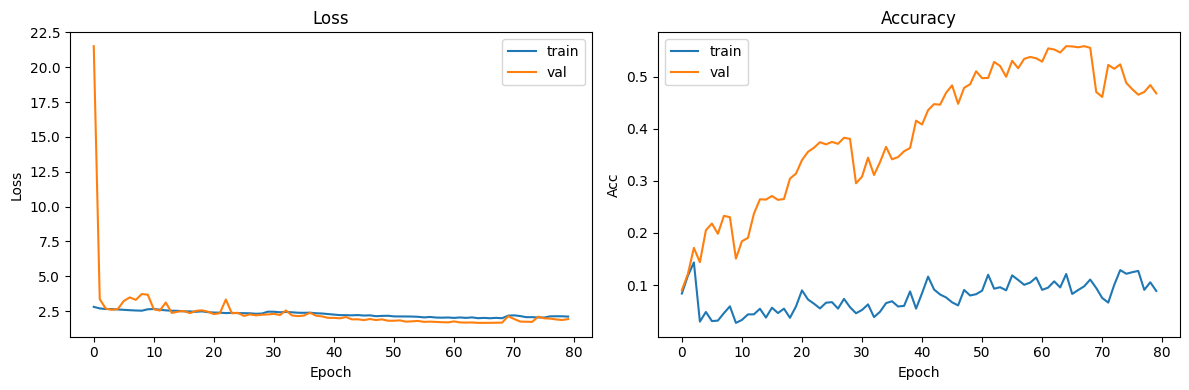

In [ ]:

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

plt.tight_layout(); plt.show()


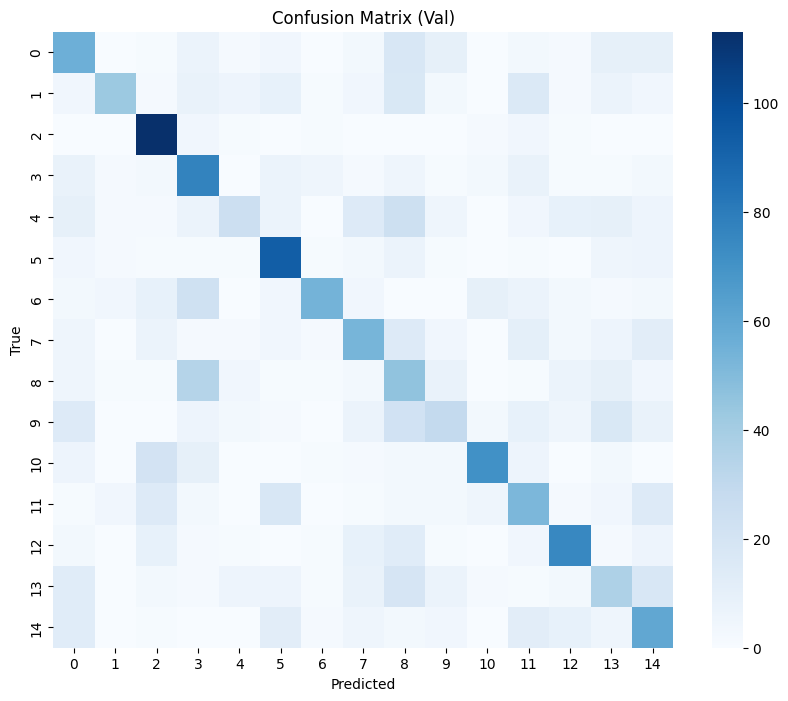

Classification Report (Val):
                    precision    recall  f1-score   support

           calling     0.3836    0.4444    0.4118       126
          clapping     0.7414    0.3413    0.4674       126
           cycling     0.6011    0.8968    0.7197       126
           dancing     0.4140    0.6111    0.4936       126
          drinking     0.4902    0.1984    0.2825       126
            eating     0.5569    0.7381    0.6348       126
          fighting     0.7714    0.4286    0.5510       126
           hugging     0.4454    0.4206    0.4327       126
          laughing     0.2359    0.3651    0.2866       126
listening_to_music     0.3671    0.2302    0.2829       126
           running     0.7396    0.5635    0.6396       126
           sitting     0.3741    0.4127    0.3925       126
          sleeping     0.6148    0.5952    0.6048       126
           texting     0.3109    0.2937    0.3020       126
      using_laptop     0.3871    0.4762    0.4270       126

         

In [ ]:
@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []
    for imgs, targets in loader:
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(np.array(targets))
    return np.concatenate(all_targets), np.concatenate(all_preds)

targets_np, preds_np = predict_all(model, val_loader, device)

cm = confusion_matrix(targets_np, preds_np)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Val)'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

print("Classification Report (Val):")
print(classification_report(
    targets_np, preds_np,
    target_names=[idx2label[i] for i in range(len(idx2label))],
    digits=4
))


**Model değerlendirme yardımcıları (accuracy_from_logits, evaluate)**

CNN’in tahmin doğruluğunu ve loss değerini validation/test setinde hesaplar.

Eğitim sürecinde her epoch sonrası modelin genelleme başarısını ölçmek için kullanılır.

**Grad-CAM açıklanabilirlik aracı (GradCAM, overlay_cam_on_image)**

CNN’in bir tahmin yaparken görüntünün hangi bölgelerine odaklandığını ısı haritası ile görselleştirir.

Eğitim sonrası hata analizi ve modelin karar mantığını anlamak için kullanılır.

In [ ]:

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    tot_loss, tot_acc, n = 0.0, 0.0, 0
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), torch.tensor(targets).to(device)
        logits = model(imgs)
        loss = criterion(logits, targets)
        bs = targets.size(0)
        tot_loss += loss.item() * bs
        tot_acc  += accuracy_from_logits(logits, targets) * bs
        n += bs
    return tot_loss/n, tot_acc/n

# Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer=None):
        self.model = model.eval()
        self.target_layer = target_layer or self._find_last_conv(model)
        self.activations, self.gradients = None, None
        self.fh = self.target_layer.register_forward_hook(self._forward_hook)
        self.bh = self.target_layer.register_full_backward_hook(self._backward_hook)
    def _find_last_conv(self, m):
        last = None
        for _, mod in m.named_modules():
            if isinstance(mod, nn.Conv2d): last = mod
        if last is None: raise ValueError("Grad-CAM için Conv2d bulunamadı.")
        return last
    def _forward_hook(self, module, inp, out): self.activations = out.detach()
    def _backward_hook(self, module, gin, gout): self.gradients = gout[0].detach()
    def __call__(self, x, index=None):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)
        if index is None: index = logits.argmax(1)
        sel = logits.gather(1, index.view(-1,1)).sum()
        sel.backward()
        grads, acts = self.gradients, self.activations
        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam_min = cam.amin(dim=(2,3), keepdim=True)
        cam_max = cam.amax(dim=(2,3), keepdim=True).clamp(min=1e-6)
        cam = (cam - cam_min) / (cam_max - cam_min)
        return logits.detach(), cam.detach()
    def remove_hooks(self):
        self.fh.remove(); self.bh.remove()

def overlay_cam_on_image(img_tensor, cam):
    img = img_tensor.detach().cpu()
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1)
    img = (img*std + mean).clamp(0,1)
    img = img.permute(1,2,0).numpy()

    import PIL.Image as PILImage
    cam_np = cam.squeeze(0).cpu().numpy()
    cam_resized = np.array(PILImage.fromarray((cam_np*255).astype(np.uint8)).resize((img.shape[1], img.shape[0])))
    cam_resized = cam_resized.astype(np.float32)/255.0

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.imshow(cam_resized, alpha=0.45)
    plt.axis('off'); plt.tight_layout(); plt.show()


Pred: dancing | True: texting


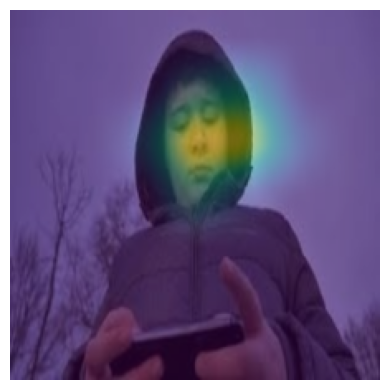

Pred: cycling | True: cycling


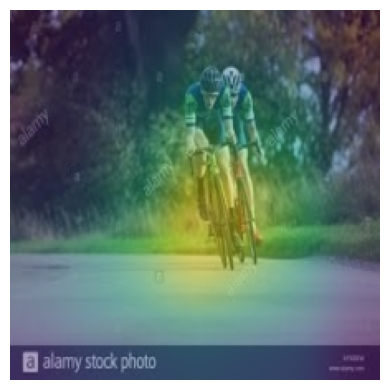

Pred: clapping | True: clapping


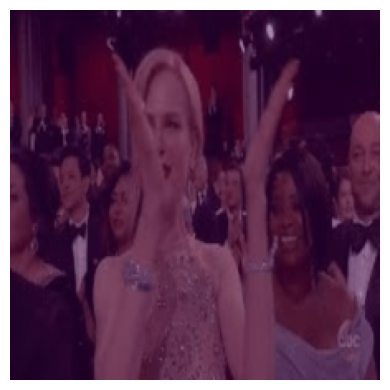

In [ ]:
gc = GradCAM(model)
imgs, tgts = next(iter(val_loader))
idxs = np.random.choice(len(imgs), size=min(3, len(imgs)), replace=False)

for i in idxs:
    x = imgs[i:i+1].to(device)
    logits, cam = gc(x)
    pred = logits.argmax(1).item()
    print(f"Pred: {idx2label[pred]} | True: {idx2label[int(tgts[i])]}")

    overlay_cam_on_image(imgs[i], cam[0])

gc.remove_hooks()


Bu fonksiyon CNN eğitiminde her epoch sonunda modelin doğruluğunu ve loss’unu ölçmek için kullanılır. Eğitim performansını izlemeyi, overfitting’i tespit etmeyi ve en iyi checkpoint’i seçmeyi sağlar.

In [ ]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot_loss, tot_correct, tot = 0.0, 0, 0
    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        tot_loss += loss.item() * targets.size(0)
        tot_correct += (outputs.argmax(1) == targets).sum().item()
        tot += targets.size(0)
    return tot_loss / tot, tot_correct / tot


Bu hücre, daha önce kaydedilmiş en iyi CNN modelini yükleyip (checkpoint), ek 40 epok boyunca ince ayar (fine-tuning) yaparak performansı artırmayı amaçlar; eğitim sırasında MixUp/CutMix veri artırma, EMA (Exponential Moving Average) ağırlık güncelleme, Cosine LR scheduleri, mixed precision (AMP), gradient clipping ve isteğe bağlı SWA (Stochastic Weight Averaging) gibi ileri teknikler kullanılır; böylece modelin daha kararlı, genellemesi güçlü ve doğruluğu yüksek hale gelmesi hedeflenir.

In [ ]:
CONT_CKPT = os.path.join(DATA_DIR, "best_enhanced_cnn.pth")
assert os.path.exists(CONT_CKPT), f"Checkpoint bulunamadı: {CONT_CKPT}"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(label2idx)
model = EnhancedCNN(num_classes=num_classes, dropout_rate=0.25, use_attention=True).to(device)


optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

ckpt = torch.load(CONT_CKPT, map_location=device)
model.load_state_dict(ckpt["model_state"])

start_epoch = ckpt.get("epoch", 0) + 1
print(f"Loaded checkpoint from epoch={ckpt.get('epoch', 'NA')}  best_val_acc={ckpt.get('best_val_acc', 'NA')}")


MORE_EPOCHS = 40
TOTAL_STEPS = MORE_EPOCHS * len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MORE_EPOCHS, eta_min=1e-6)


EMA_DECAY = 0.999
ema_state = {k: v.detach().clone() for k, v in model.state_dict().items() if v.dtype.is_floating_point}

@torch.no_grad()
def ema_update(model):
    for k, v in model.state_dict().items():
        if k in ema_state and v.dtype.is_floating_point:
            ema_state[k].mul_(EMA_DECAY).add_(v.detach(), alpha=1.0-EMA_DECAY)

def load_ema_weights(model):
    missing = model.load_state_dict(ema_state, strict=False)
    return missing


USE_MIXUP = True
USE_CUTMIX = True
MIXUP_ALPHA = 0.3
CUTMIX_ALPHA = 1.0

def aug_prob(epoch, max_epoch):

    return max(0.0, 1.0 - epoch / (0.7 * max_epoch))


USE_SWA = True
SWA_LAST = 5
if USE_SWA:
    swa_model = torch.optim.swa_utils.AveragedModel(model)
    swa_scheduler = torch.optim.swa_utils.SWALR(optimizer, swa_lr=5e-5)


scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
GRAD_CLIP = 0.5

best_val_acc = float(ckpt.get("best_val_acc", 0.0))
save_path = os.path.join(DATA_DIR, "best_enhanced_cnn_continued.pth")
history2 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for e in range(1, MORE_EPOCHS+1):
    epoch = start_epoch + e - 1
    model.train()
    t0 = time.time()
    run_loss, run_acc, n = 0.0, 0.0, 0

    p_aug = aug_prob(e, MORE_EPOCHS)
    for imgs, targets in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)


        tag = None
        if e > 2 and p_aug > 0:
            r = random.random()
            if USE_MIXUP and r < 0.5 * p_aug:
                imgs, ya, yb, lam = mixup_data(imgs, targets, alpha=MIXUP_ALPHA)
                tag = ("mixup", (ya, yb, lam))
            elif USE_CUTMIX and r < 0.8 * p_aug:
                imgs, ya, yb, lam = cutmix_data(imgs, targets, alpha=CUTMIX_ALPHA)
                tag = ("cutmix", (ya, yb, lam))

        optimizer.zero_grad(set_to_none=True)
        if scaler.is_enabled():
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss = mixup_criterion(criterion, logits, *tag[1]) if tag else criterion(logits, targets)
        else:
            logits = model(imgs)
            loss = mixup_criterion(criterion, logits, *tag[1]) if tag else criterion(logits, targets)

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()


        ema_update(model)

        bs = targets.size(0)
        run_loss += loss.item() * bs
        if not tag:
            run_acc += (logits.argmax(1) == targets).float().sum().item()
        n += bs

    train_loss = run_loss / n
    train_acc  = (run_acc / n) if run_acc > 0 else float("nan")


    if USE_SWA and e > MORE_EPOCHS - SWA_LAST:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()

    orig_state = {k: v.clone() for k, v in model.state_dict().items() if v.dtype.is_floating_point}
    load_ema_weights(model)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    model.load_state_dict({**model.state_dict(), **orig_state}, strict=False)

    history2["train_loss"].append(train_loss)
    history2["train_acc"].append(train_acc)
    history2["val_loss"].append(val_loss)
    history2["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": ema_state,
            "optimizer_state": optimizer.state_dict(),
            "epoch": epoch,
            "best_val_acc": best_val_acc
        }, save_path)
        print(f"  ✅ Yeni en iyi! (EMA) Val Acc={val_acc:.4f} -> {save_path}")

    dt = time.time() - t0
    print(f"[{epoch:03d}] train_loss={train_loss:.4f} acc={'{:.4f}'.format(train_acc) if run_acc>0 else 'aug'} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | lr={optimizer.param_groups[0]['lr']:.2e} | {dt:.1f}s")


if USE_SWA:

    torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)

    torch.save({
        "model_state": swa_model.state_dict(),
        "epoch": start_epoch + MORE_EPOCHS - 1,
        "best_val_acc": best_val_acc
    }, os.path.join(DATA_DIR, "best_enhanced_cnn_continued_swa.pth"))

print(f"Done. Best (EMA) Val Acc: {best_val_acc:.4f}")


Loaded checkpoint from epoch=65  best_val_acc=0.5582010582010583


/tmp/ipython-input-2321055702.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-2321055702.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[066] train_loss=1.6282 acc=0.5230 | val_loss=1.5394 acc=0.5561 | lr=3.00e-04 | 74.6s
  ✅ Yeni en iyi! (EMA) Val Acc=0.5593 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn_continued.pth
[067] train_loss=1.6147 acc=0.5249 | val_loss=1.5314 acc=0.5593 | lr=2.98e-04 | 78.9s
[068] train_loss=1.9301 acc=0.1457 | val_loss=1.5295 acc=0.5593 | lr=2.96e-04 | 79.7s
  ✅ Yeni en iyi! (EMA) Val Acc=0.5614 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn_continued.pth
[069] train_loss=1.9038 acc=0.1878 | val_loss=1.5276 acc=0.5614 | lr=2.93e-04 | 80.4s
  ✅ Yeni en iyi! (EMA) Val Acc=0.5635 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn_continued.pth
[070] train_loss=1.9623 acc=0.1776 | val_loss=1.5291 acc=0.5635 | lr=2.89e-04 | 113.3s
  ✅ Yeni en iyi! (EMA) Val Acc=0.5646 -> /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn_continued.pth
[071] train_loss=1.9537 acc=0.1482 | val_loss=1.5282 acc=0.5646 | lr=2.84e-04 | 116.7

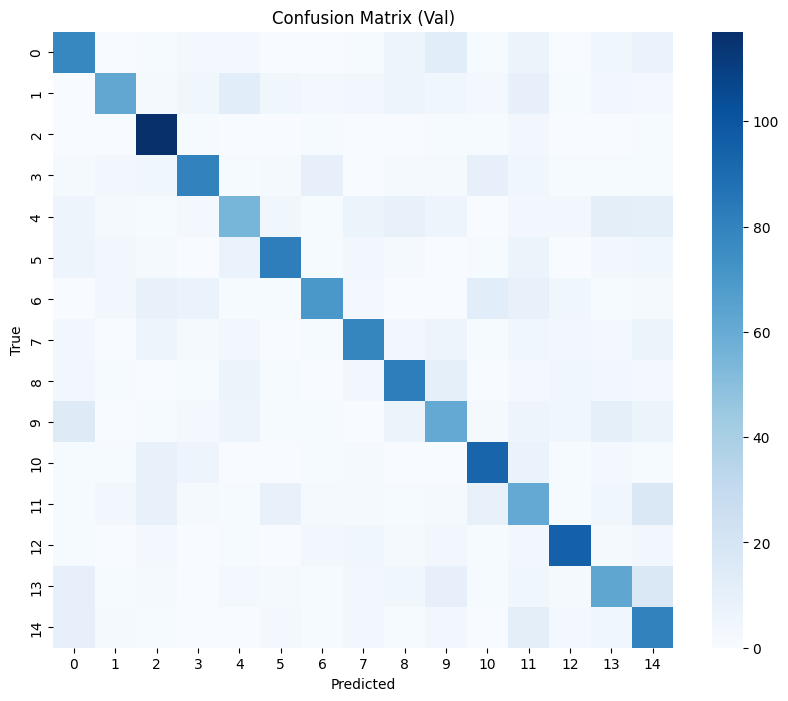

Classification Report (Val):
                    precision    recall  f1-score   support

           calling     0.5652    0.6190    0.5909       126
          clapping     0.7294    0.4921    0.5877       126
           cycling     0.6964    0.9286    0.7959       126
           dancing     0.7018    0.6349    0.6667       126
          drinking     0.5340    0.4365    0.4803       126
            eating     0.7387    0.6508    0.6920       126
          fighting     0.7216    0.5556    0.6278       126
           hugging     0.6639    0.6270    0.6449       126
          laughing     0.6457    0.6508    0.6482       126
listening_to_music     0.4880    0.4841    0.4861       126
           running     0.6838    0.7381    0.7099       126
           sitting     0.4067    0.4841    0.4420       126
          sleeping     0.7480    0.7540    0.7510       126
           texting     0.5122    0.5000    0.5060       126
      using_laptop     0.4790    0.6349    0.5461       126

         

In [ ]:
@torch.no_grad()
def predict_all(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []
    for imgs, targets in loader:
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(np.array(targets))
    return np.concatenate(all_targets), np.concatenate(all_preds)

targets_np, preds_np = predict_all(model, val_loader, device)

cm = confusion_matrix(targets_np, preds_np)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Val)'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

print("Classification Report (Val):")
print(classification_report(
    targets_np, preds_np,
    target_names=[idx2label[i] for i in range(len(idx2label))],
    digits=4
))


Bu grafikte ilk epoklarda train loss dalgalı bir şekilde başladı. Bunun sebebi büyük ihtimalle MixUp/Cutmix gibi agresif augmentasyon yaptığım içindir.
Epoklar ilerledikçe train loss istikrarlı bir şekilde düşmüş ve 30. epok sonunda validation loss ile benzer seviyeye inmiştir. Validation loss baştan sona daha düşük seyretmiş ve sürekli azalmış bu da modelin genelleme kapasitesinin arttığını göstermiştir.
Accuracy grafiğine baktığımızda başlangıçta train accuracy düşük ve dalgalı bir grafik çizmiş bunun sebebi de agresif augmentasyon kaynaklıdır.
15-20 epoklarda sonra train accuracy hızla yükselmiş ve 30'dan sonra %60 seviyelerini oturmuştur. Validation accuracy ise baştan itibaren stabil ve sürekli artarak %55'ten %61 civarına gelmiştir. Burada eğitim strajesindeki EMA,MixUp/Cutmix ve SWA gibi teknikler bu kararlı öğrenmeye katkı sağlamıştır.

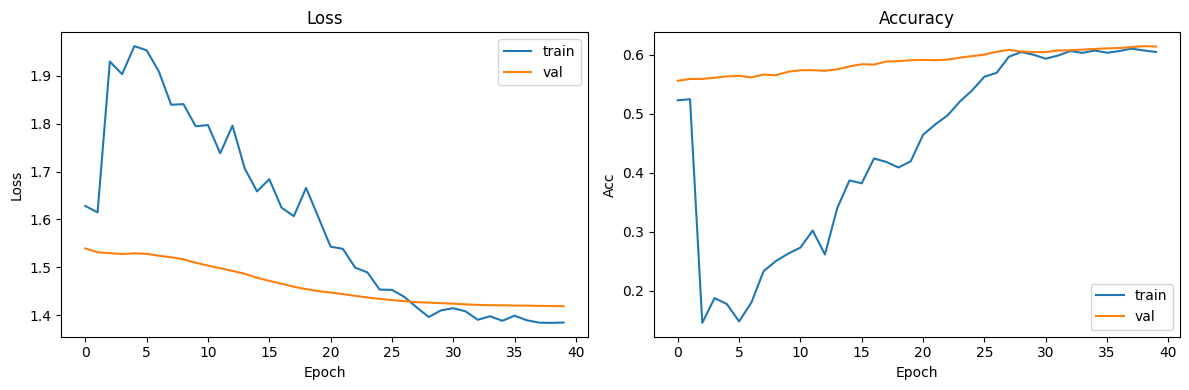

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history2["train_loss"], label="train")
plt.plot(history2["val_loss"], label="val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history2["train_acc"], label="train")
plt.plot(history2["val_acc"], label="val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend()

plt.tight_layout(); plt.show()


LR (2e-5), MixUp/Cutmix kapalı ve label smoothing=0 ayarlarıyla 8 epokluk kısa bir fine-tune yapılmıştır.

In [ ]:

from collections import defaultdict
import torch, time, numpy as np, random
import torch.nn as nn
import torch.optim as optim


ckpt_path = os.path.join(DATA_DIR, "best_enhanced_cnn_continued.pth")
if not os.path.exists(ckpt_path):
    ckpt_path = os.path.join(DATA_DIR, "best_enhanced_cnn.pth")
print("Yüklenecek checkpoint:", ckpt_path)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"] if "model_state" in ckpt else ckpt["model_state_dict"], strict=True)


for pg in optimizer.param_groups:
    pg['lr'] = 2e-5
cfg.use_mixup = False
cfg.use_cutmix = False
cfg.label_smoothing = 0.0

criterion_ft = nn.CrossEntropyLoss()

best_val_acc_ft1 = 0.0
epochs_ft1 = 8
history_ft1 = defaultdict(list)

print("FT-1 başlıyor (MixUp/CutMix KAPALI, lr=%.1e)..." % optimizer.param_groups[0]['lr'])
for epoch in range(1, epochs_ft1+1):
    model.train()
    t0 = time.time()
    run_loss, run_acc, n = 0.0, 0.0, 0

    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion_ft(logits, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        optimizer.step()

        bs = targets.size(0)
        run_loss += loss.item() * bs
        run_acc  += (logits.argmax(1) == targets).float().sum().item()
        n += bs

    train_loss = run_loss / n
    train_acc  = run_acc / n
    val_loss, val_acc = evaluate(model, val_loader, criterion_ft, device)


    if val_acc > best_val_acc_ft1:
        best_val_acc_ft1 = val_acc
        torch.save({"model_state": model.state_dict(),
                    "epoch": epoch,
                    "best_val_acc": best_val_acc_ft1},
                   os.path.join(DATA_DIR, "best_finetune_phase1.pth"))
        print("  ✅ [FT-1] Yeni en iyi! Val Acc=%.4f" % val_acc)


    print(f"[FT1 {epoch:02d}/{epochs_ft1}] train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | {time.time()-t0:.1f}s")

print("FT-1 bitti. En iyi Val Acc: %.4f" % best_val_acc_ft1)


Yüklenecek checkpoint: /content/drive/MyDrive/Human Action Recognition/best_enhanced_cnn_continued.pth
FT-1 başlıyor (MixUp/CutMix KAPALI, lr=2.0e-05)...
  ✅ [FT-1] Yeni en iyi! Val Acc=0.5926
[FT1 01/8] train_loss=1.3597 acc=0.5663 | val_loss=1.3137 acc=0.5926 | lr=2.00e-05 | 130.0s
[FT1 02/8] train_loss=1.2910 acc=0.5885 | val_loss=1.3249 acc=0.5910 | lr=2.00e-05 | 126.7s
  ✅ [FT-1] Yeni en iyi! Val Acc=0.6101
[FT1 03/8] train_loss=1.2696 acc=0.5948 | val_loss=1.2754 acc=0.6101 | lr=2.00e-05 | 126.2s
[FT1 04/8] train_loss=1.2511 acc=0.5963 | val_loss=1.2997 acc=0.6074 | lr=2.00e-05 | 136.2s
[FT1 05/8] train_loss=1.2379 acc=0.6030 | val_loss=1.3028 acc=0.5984 | lr=2.00e-05 | 125.1s
[FT1 06/8] train_loss=1.2268 acc=0.6127 | val_loss=1.2703 acc=0.6048 | lr=2.00e-05 | 125.1s
  ✅ [FT-1] Yeni en iyi! Val Acc=0.6175
[FT1 07/8] train_loss=1.2249 acc=0.6079 | val_loss=1.2631 acc=0.6175 | lr=2.00e-05 | 127.4s
[FT1 08/8] train_loss=1.2196 acc=0.6089 | val_loss=1.2739 acc=0.6106 | lr=2.00e-05 | 

 IMG_SIZE=320, augment hafif, LR (1e-5) ile 8 epokluk kısa bir fine-tune gerçekleştirilmiştir.

In [ ]:

import torchvision.transforms as T
from torch.utils.data import DataLoader

IMG_SIZE_FT2 = 320

train_transform_ft2 = T.Compose([
    T.Resize(int(IMG_SIZE_FT2*1.10)),
    T.RandomResizedCrop(IMG_SIZE_FT2, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform_ft2 = T.Compose([
    T.Resize(int(IMG_SIZE_FT2*1.10)),
    T.CenterCrop(IMG_SIZE_FT2),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


train_dataset_ft2 = HARDataset(df=train_df, images_dir=TRAIN_DIR,
                               transform=train_transform_ft2, label2idx=label2idx, has_labels=True)
val_dataset_ft2   = HARDataset(df=val_df,   images_dir=TRAIN_DIR,
                               transform=val_transform_ft2,   label2idx=label2idx, has_labels=True)

train_loader_ft2 = DataLoader(train_dataset_ft2, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, pin_memory=torch.cuda.is_available())
val_loader_ft2   = DataLoader(val_dataset_ft2, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())


ckpt_p1 = os.path.join(DATA_DIR, "best_finetune_phase1.pth")
if os.path.exists(ckpt_p1):
    print("FT-2 için yükleniyor:", ckpt_p1)
    model.load_state_dict(torch.load(ckpt_p1, map_location=device)["model_state"], strict=True)


for pg in optimizer.param_groups:
    pg['lr'] = 1e-5

criterion_ft2 = nn.CrossEntropyLoss()
epochs_ft2 = 8
best_val_acc_ft2 = 0.0

print("FT-2 başlıyor (IMG_SIZE=320, lr=%.1e)..." % optimizer.param_groups[0]['lr'])
for epoch in range(1, epochs_ft2+1):
    model.train()
    t0 = time.time()
    run_loss, run_acc, n = 0.0, 0.0, 0

    for imgs, targets in train_loader_ft2:
        imgs, targets = imgs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)
        loss = criterion_ft2(logits, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        optimizer.step()

        bs = targets.size(0)
        run_loss += loss.item() * bs
        run_acc  += (logits.argmax(1) == targets).float().sum().item()
        n += bs

    train_loss = run_loss / n
    train_acc  = run_acc / n
    val_loss, val_acc = evaluate(model, val_loader_ft2, criterion_ft2, device)

    if val_acc > best_val_acc_ft2:
        best_val_acc_ft2 = val_acc
        torch.save({"model_state": model.state_dict(),
                    "epoch": epoch,
                    "best_val_acc": best_val_acc_ft2},
                   os.path.join(DATA_DIR, "best_finetune_phase2_320.pth"))
        print("  ✅ [FT-2] Yeni en iyi! Val Acc=%.4f" % val_acc)


    print(f"[FT2 {epoch:02d}/{epochs_ft2}] train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e} | {time.time()-t0:.1f}s")

print("FT-2 bitti. En iyi Val Acc: %.4f" % best_val_acc_ft2)


FT-2 için yükleniyor: /content/drive/MyDrive/Human Action Recognition/best_finetune_phase1.pth
FT-2 başlıyor (IMG_SIZE=320, lr=1.0e-05)...
  ✅ [FT-2] Yeni en iyi! Val Acc=0.5926
[FT2 01/8] train_loss=1.1430 acc=0.6331 | val_loss=1.3079 acc=0.5926 | lr=1.00e-05 | 258.2s
  ✅ [FT-2] Yeni en iyi! Val Acc=0.6053
[FT2 02/8] train_loss=1.0389 acc=0.6696 | val_loss=1.2686 acc=0.6053 | lr=1.00e-05 | 247.9s
  ✅ [FT-2] Yeni en iyi! Val Acc=0.6101
[FT2 03/8] train_loss=1.0012 acc=0.6808 | val_loss=1.2631 acc=0.6101 | lr=1.00e-05 | 254.3s
  ✅ [FT-2] Yeni en iyi! Val Acc=0.6153
[FT2 04/8] train_loss=0.9738 acc=0.6898 | val_loss=1.2657 acc=0.6153 | lr=1.00e-05 | 254.4s
  ✅ [FT-2] Yeni en iyi! Val Acc=0.6228
[FT2 05/8] train_loss=0.9205 acc=0.7050 | val_loss=1.2471 acc=0.6228 | lr=1.00e-05 | 254.4s
[FT2 06/8] train_loss=0.9208 acc=0.7071 | val_loss=1.2320 acc=0.6206 | lr=1.00e-05 | 253.4s
  ✅ [FT-2] Yeni en iyi! Val Acc=0.6238
[FT2 07/8] train_loss=0.8909 acc=0.7145 | val_loss=1.2413 acc=0.6238 | lr=1

Burada modeli çoklu kırpma ve flip ile test edip daha güçlü bir doğruluk ölçümü yapılmıştır. Test sonucunda yaklaşık olarak %62'lik bir doğruluk sonucu elde edilmiştir.

In [ ]:
@torch.no_grad()
def evaluate_tta(model, loader, device, n_flips=2, five_crop=True, crop_size=None):
    model.eval()
    correct, total = 0, 0

    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)


        logits_sum = torch.zeros(imgs.size(0), len(label2idx), device=device)


        flip_variants = [False, True][:max(1, n_flips)]
        for do_flip in flip_variants:
            x = torch.flip(imgs, dims=[3]) if do_flip else imgs

            if five_crop:

                b, c, h, w = x.shape
                sz = crop_size if crop_size else min(h, w)
                crops = TF.five_crop(x, sz)

                partial = 0
                for crop in crops:

                    partial = partial + model(crop)
                logits_sum += partial / 5.0
            else:
                logits_sum += model(x)

        logits = logits_sum / float(len(flip_variants))
        pred = logits.argmax(1)
        correct += (pred == targets).sum().item()
        total   += targets.size(0)

    return correct / total

ckpt_tta = os.path.join(DATA_DIR, "best_finetune_phase2_320.pth")
if os.path.exists(ckpt_tta):
    model.load_state_dict(torch.load(ckpt_tta, map_location=device)["model_state"], strict=True)

tta_acc = evaluate_tta(model, val_loader_ft2, device, n_flips=2, five_crop=True, crop_size=IMG_SIZE_FT2)
print(f"TTA Val Acc: {tta_acc:.4f}")


TTA Val Acc: 0.6286
